# Investigating High Traffic Indicators on Westbound I-94

This project takes a deeper analysis of the traffic patterns of interstate 94 in connection to some major factors, such as:
* Weather types and conditions, including the amount of rain, cloud, and snow
* Time of day, time of the week, etc.
* Temperature
* U.S. Holidays

The ***I-94*** is one of the longest U.S. interstate, streching ***1,585 miles*** along ***east-west*** from Billings, Montana, to Port Huron, Michigan. In deciding the project's **purpose**, we took into consideration the following factors that make I-94's traffic analysis particularly valuable for improving the overall safety and efficiency in the highway: 
* I-94 connects to near ***seven major cities***, including Minneapolis-St. Paul in Minnesota, Milwaukee in Wisconsin, and Chicago in Illinois, making it a vital transportation artery in the Midwest.
* It's economic impact on faciliatating the ***movement of goods*** and people between major population centers, industrial hubs, and distribution centers. 
* Notorious traffic volume between the Twin Cities (Minneapolis and St. Paul).

A **use case** of the analysis could be better understanding of what a normal range for traffic volume looks like for I-94, more accurately predict heavy traffic conditions, and plan beforehand for such situations based on the indicators to avoid any mishaps.

# Finding the Right Dataset
For this analysis, we found  the [dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) collected by John Hogue in the UC Irvine Machine Learning Repository that provides hourly ***Mineapolis to St. Paul*** traffic details from ***2012 - 2014/18?***.

Because the dataset found only covers Mineapolis to St. Paul traffic going **east to west**, we will focus the findings of our analysis to **I-94 Westbound** traffic in order to avoid generalization. This segment of I-94 is also notoriously known for its high traffic volume. Therefore, the dataset seems to be a good fit without detering too far from the original goal.

<center><img src=".\images\i94_map.jpg" alt="I-94 Map" width="500" height="300"></center>

In [67]:
# Import the data
import pandas as pd

i94_traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', encoding='latin1')
i94_traffic.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767


In [68]:
i94_traffic.tail(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [69]:
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### Initial Observations

* ***48204*** entries and ***9*** columns.
* Type correction is needed for `date_time` for accurate time-based analysis. The rest of the data types seem consistent with the Hogue's [documentation](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) for the dataset.
* `holiday` has only ***61 non-null*** values where most of them seem to be ***NaN*** values at a glance. According to the original [dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume), there should have no missing data for this column. We'll be taking a closer look at the `holiday` column to identify the issue.

In [70]:
# Analyzing the holiday column for NaN values
i94_traffic['holiday'].value_counts(dropna=False)

holiday
NaN                          48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

After checking the original [CSV file](https://archive.ics.uci.edu/static/public/492/metro+interstate+traffic+volume.zip) using `COUNTIF`, the fields where no holidays take place have exactly ***48143*** ***"None"*** entries. This explains why ***48143*** entries are `NaN` as `pandas` probably interepreted `None` as missing values while importing the dataset.

## Cleaning and Prepping the Dataset for a Meaninful Analysis

1. Replace the `NaN` missing values. In this case, it would be accurate to replace the NaN values with the string ***"None"***.
2. Correct the `dtype` for `date_time` column for meaningful time-based analysis.
3. Check for unexpected values in the *categorical* columns. We'll look at the *numerical* columns for outliers during the analysis stage on as needed basis. We'll look for any outliers in the *numerical* columns: `temp`, `snow_1h`, `rain_1h`, `clouds_all`, `date_time`, and `traffic_volume`.

### 1. Replace the NaN missing values with "None":

In [71]:
# Replace the missing values in the holiday column with "None"
i94_traffic['holiday'] = i94_traffic['holiday'].fillna("None")

# Validate changes
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


All ***48204*** entries are non-null.

### 2. Convert the date column to a datetime object for time-based analysis:

In [72]:
# Get the current date type for date_time column 
i94_traffic['date_time'].dtype

dtype('O')

In [73]:
# Convert the date_time column from 'object' to a 'datetime' object
i94_traffic['date_time'] = pd.to_datetime(i94_traffic['date_time'])

i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


`date_time` column is now of *datetime64[ns]* type.

### 3. Check for unexpected values in the Categorical Columns:

We start by checking the *categorical* data to ensure the values are relevant and get of rid of any unexpected values.

In [74]:
i94_traffic['weather_main'].value_counts()

weather_main
Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: count, dtype: int64

>>i94_traffic['weather_description'].value_counts()

>>i94_traffic['weather_description'].str.extract(pattern)

We could potentially extract severity levels of each weather type from the weather description. For now, we'll keep this in the back burner since we're not sure if it's relevant to the analysis and how much value it will provide yet.

We noticed a discrepency in the rain data.

In [181]:
# Check the rain column
i94_traffic['rain_1h'].value_counts(bins = 10).sort_index()

(-0.0566, 5.563]    47928
(5.563, 11.126]       201
(11.126, 16.689]       42
(16.689, 22.252]       16
(22.252, 27.815]       12
(27.815, 33.378]        3
(33.378, 38.941]        0
(38.941, 44.504]        1
(44.504, 50.067]        0
(50.067, 55.63]         1
Name: count, dtype: int64

In [182]:
# Replace rain column where rain volume in a hour is greater than 1000
i94_traffic.loc[i94_traffic['rain_1h'] > 1000, 'rain_1h'] = 0.00
i94_traffic['rain_1h'].value_counts(bins = 10).sort_index()

(-0.0566, 5.563]    47928
(5.563, 11.126]       201
(11.126, 16.689]       42
(16.689, 22.252]       16
(22.252, 27.815]       12
(27.815, 33.378]        3
(33.378, 38.941]        0
(38.941, 44.504]        1
(44.504, 50.067]        0
(50.067, 55.63]         1
Name: count, dtype: int64

We see a more accurate distribution of rain volume. All the other columns seem to be consistent and represent accurate data.

## Exploration: Finding Patterns in the Traffic Volume

We'll now explore the distribution of a few columns for our analysis and also key an eye for any ***outliers*** in the *numerical* columns: `temp`, `snow_1h`, `rain_1h`, `clouds_all`, `date_time`, and `traffic_volume`.

We'll try to find any patterns in the traffic volume. We'll look at a few things:

1. Distribution of traffic volume. We'll pursue any leads to our investigation.
2. Time-based analysis of traffic by hour, weeek, etc and any difference in business days vs. weekends. 
3. Can we derive any relaible correlations between traffic volume and weather, holidays, and temperature indicators? We'll pursue strong correlations further.

### Understanding the Distribution of Traffic Volume

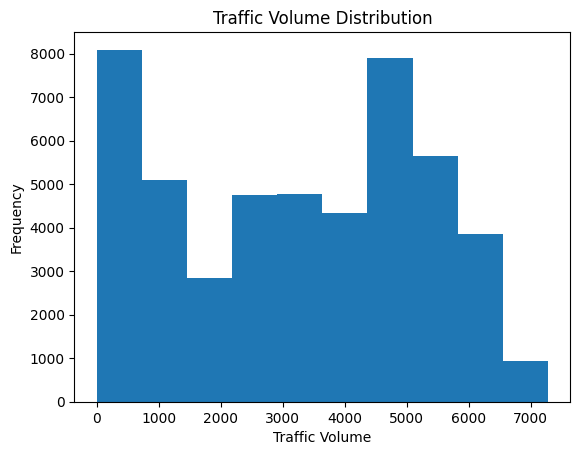

In [183]:
import matplotlib.pyplot as plt

# Added inline magic to generate graphs in Jupyter Notebook
%matplotlib inline

traffic_vol = i94_traffic['traffic_volume']

# Visualize the distribution of traffic volume
traffic_vol.plot.hist(xlabel='Traffic Volume', title='Traffic Volume Distribution')
plt.show()


In [184]:
# Generate key insights about Traffic Volume
traffic_vol.describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

**Quick Observations:**

* The traffic volume range from ***0 to 7280***, with the majority of the bulk distributed between ***0 - 500*** (8000 count) and ***4500 - 5000*** (8000 count).
* About 25% of the time, there were 1,193 or fewer vehicles each hour. One possibility is that this is mostly nighttime traffic.
* About 75% of the time, there were 4,933 or fewer vechiles each hour. The rest of the 25%, the traffic exceeded 4,933 vehicles.

The possibility of varying nighttime vs. daytime traffic could give a different perspective to our analysis.

### Exploration: Nighttime VS Daytime Traffic Comparisions

Below, we seggregated the dataset into two parts:
* Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
* Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

The `date_time` column has already been typed correctly in the cleaning stage to derive meaninful analysis.

In [202]:
import datetime as dt

date_col = i94_traffic['date_time']

# Create a boolean for daytime data selection - between 7:00:00 incl. to 19:00:00 excl.
daytime_bool = (date_col.dt.time >= dt.time(7, 0, 0)) & (date_col.dt.time < dt.time(19, 0, 0))

# Isolate daytime traffic from the original dataset based on the boolean criteria
daytime_traffic = i94_traffic.copy().loc[daytime_bool]

# Verify the daytime traffic data
daytime_traffic['date_time'].dt.time.value_counts().sort_index()

date_time
07:00:00    2079
08:00:00    2080
09:00:00    2018
10:00:00    2078
11:00:00    1952
12:00:00    1955
13:00:00    1905
14:00:00    1969
15:00:00    1934
16:00:00    1988
17:00:00    1933
18:00:00    1986
Name: count, dtype: int64

In [230]:
# Create a boolean for nighttime data selection - between 7:00:00 excl. to 19:00:00 incl.
nighttime_bool = (date_col.dt.time >= dt.time(19, 0, 0)) | (date_col.dt.time < dt.time(7, 0, 0))

# Isolate daytime traffic from the original dataset based on the boolean criteria
nighttime_traffic = i94_traffic.copy().loc[nighttime_bool]

# Verify the daytime traffic data
# custom_index = ['19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', '00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00']
nighttime_traffic['date_time'].dt.time.value_counts().sort_index()

date_time
00:00:00    2037
01:00:00    2049
02:00:00    2019
03:00:00    2025
04:00:00    2091
05:00:00    2063
06:00:00    2087
19:00:00    1961
20:00:00    1979
21:00:00    1982
22:00:00    1994
23:00:00    2040
Name: count, dtype: int64